In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

2024-08-08 12:21:31.021303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 12:21:31.060409: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_images_path = 'data/Training/images'
train_masks_path = 'data/Training/masks'
val_images_path = 'data/Validation/images'
val_masks_path = 'data/Validation/masks'
test_images_path = 'data/Test/images'
test_masks_path = 'data/Test/masks'

In [3]:
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    image_filenames = os.listdir(image_dir)
    for img_filename in image_filenames:
        img = tf.io.read_file(os.path.join(image_dir, img_filename))
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [128, 128])
        images.append(img)

        mask_filename = img_filename.replace('.png', '.png')
        mask = tf.io.read_file(os.path.join(mask_dir, mask_filename))
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, [128, 128])
        masks.append(mask)

    images = tf.stack(images)
    masks = tf.stack(masks)
    return images, masks

In [4]:
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path)
val_images, val_masks = load_images_and_masks(val_images_path, val_masks_path)
test_images, test_masks = load_images_and_masks(test_images_path, test_masks_path)

train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

train_masks = train_masks / 255.0
val_masks = val_masks / 255.0
test_masks = test_masks / 255.0

train_masks = tf.cast(train_masks > 0.5, tf.float32)
val_masks = tf.cast(val_masks > 0.5, tf.float32)
test_masks = tf.cast(test_masks > 0.5, tf.float32)


2024-08-08 12:21:32.053278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 12:21:32.070593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 12:21:32.070728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 12:21:32.071053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other 

In [5]:
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_masks, augment=True, seed=seed)

image_generator = image_datagen.flow(train_images, batch_size=16, seed=seed)
mask_generator = mask_datagen.flow(train_masks, batch_size=16, seed=seed)

train_generator = zip(image_generator, mask_generator)

def unet_model(output_channels):
    inputs = keras.Input(shape=[128, 128, 3])

    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c3)
    c4 = layers.BatchNormalization()(c4)

    u1 = layers.UpSampling2D(size=(2, 2))(c4)
    u1 = layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    u1 = layers.BatchNormalization()(u1)
    
    u2 = layers.UpSampling2D(size=(2, 2))(u1)
    u2 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    u2 = layers.BatchNormalization()(u2)
    
    u3 = layers.UpSampling2D(size=(2, 2))(u2)
    u3 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    u3 = layers.BatchNormalization()(u3)

    outputs = layers.Conv2D(output_channels, 1, activation='sigmoid')(u3)
    model = keras.Model(inputs, outputs)
    return model

model = unet_model(1)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=200,
    batch_size=64,
)

Epoch 1/200


2024-08-08 12:21:36.779342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-08-08 12:21:38.196034: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x760335dfd4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-08 12:21:38.196054: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-08 12:21:38.198425: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-08 12:21:38.208259: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /us

8/8 [==============================] - 21s 1s/step - loss: 0.5409 - accuracy: 0.7438 - val_loss: 0.6871 - val_accuracy: 0.5321
Epoch 2/200
8/8 [==============================] - 2s 232ms/step - loss: 0.3849 - accuracy: 0.8266 - val_loss: 0.6899 - val_accuracy: 0.5128
Epoch 3/200
8/8 [==============================] - 2s 231ms/step - loss: 0.3485 - accuracy: 0.8472 - val_loss: 0.7072 - val_accuracy: 0.5128
Epoch 4/200
8/8 [==============================] - 2s 229ms/step - loss: 0.3286 - accuracy: 0.8604 - val_loss: 0.7495 - val_accuracy: 0.5128
Epoch 5/200
8/8 [==============================] - 2s 235ms/step - loss: 0.2976 - accuracy: 0.8761 - val_loss: 0.7634 - val_accuracy: 0.5128
Epoch 6/200
8/8 [==============================] - 2s 234ms/step - loss: 0.2821 - accuracy: 0.8808 - val_loss: 0.8409 - val_accuracy: 0.5128
Epoch 7/200
8/8 [==============================] - 2s 233ms/step - loss: 0.2854 - accuracy: 0.8793 - val_loss: 0.8820 - val_accuracy: 0.5128
Epoch 8/200
8/8 [==========

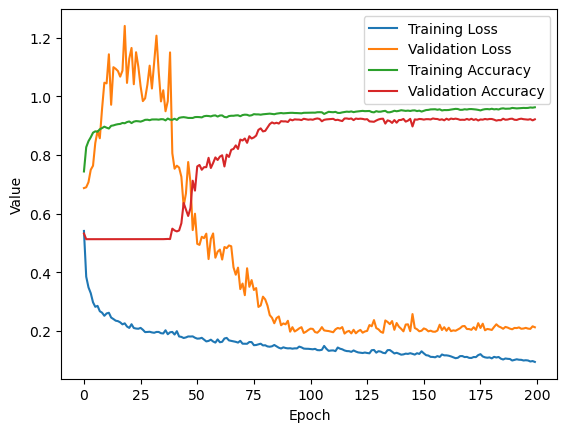

4/4 [==============================] - 0s 28ms/step - loss: 0.2123 - accuracy: 0.9218
Validation loss: 0.21234136819839478
Validation accuracy: 0.9217736721038818


In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

val_loss, val_accuracy = model.evaluate(val_images, val_masks)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


In [8]:
model.save("./models/model.h5")

In [24]:
def display_predictions(images, predictions, masks=None, num=1):
    plt.figure(figsize=(20, 10))
    for i in range(num):
        plt.subplot(2 if masks is None else 3, num, i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
        plt.title("Input Image")
        
        if masks is not None:
            plt.subplot(2 if masks is None else 3, num, i + 1 + num)
            plt.imshow(tf.keras.preprocessing.image.array_to_img(masks[i]))
            plt.title("True Mask")
        
        plt.subplot(2 if masks is None else 3, num, i + 1 + (num if masks is None else 2*num))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(predictions[i]))
        plt.title("Predicted Mask")
    
    plt.show()


1/1 [==============================] - 0s 225ms/step


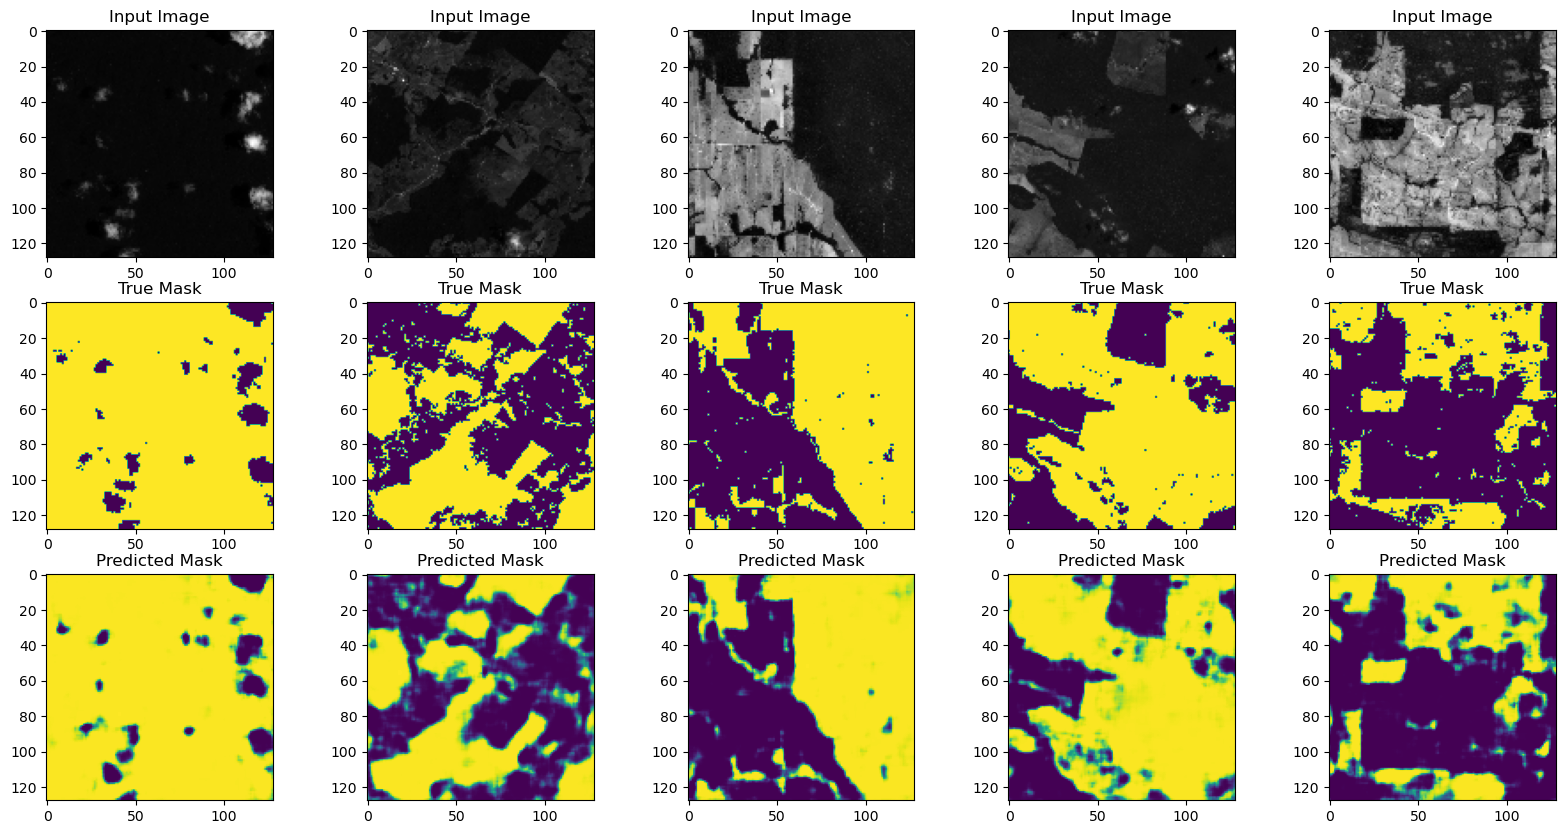

In [12]:
model = keras.models.load_model("./models/model.h5")
predictions = model.predict(test_images[:5])
display_predictions(test_images[:5], test_masks[:5], predictions, 5)